In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchmetrics.functional import pairwise_cosine_similarity

import pickle
import PIL.Image as Image
import cv2
from skimage.metrics import structural_similarity

## Model declarations 

In [2]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=588, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Misc functions

In [3]:
def weights_init(m):
    try:
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.weight' % m._get_name())
    try:
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.bias' % m._get_name())

## Data functions

In [4]:
class Dataset_from_Image(Dataset):
    def __init__(self, imgs, labs, transform=None):
        self.imgs = imgs # img paths
        self.labs = labs # labs is ndarray
        self.transform = transform
        del imgs, labs

    def __len__(self):
        return self.labs.shape[0]

    def __getitem__(self, idx):
        lab = self.labs[idx]
        img = Image.open(self.imgs[idx])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = self.transform(img)
        return img, lab

In [5]:
class DRData(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.labels = pd.read_csv(os.path.join(data_path, 'data_labels.csv'))
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]
    
    def get_filename(self, idx):
        return self.labels.loc[idx, 'image']

    def __getitem__(self, idx):
        lab = self.labels.loc[idx, 'level']
        img = Image.open(os.path.join(self.data_path, 'images', self.labels.loc[idx, 'image']+'.jpeg'))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, lab

In [6]:
def load_data():
    data_params = {}
    
    # 32 - 768, 40 - 1200, 50 - 2028
    data_params['shape_img'] = (40, 40)
    data_params['num_classes'] = 5
    data_params['channel'] = 3
    data_params['hidden'] = 1200
    data_params['lfw_path'] = os.path.join(root_path, '../data/lfw')
    data_params['dst'] = DRData('../data/dr/', transform=transforms.Compose([transforms.Resize(size=data_params['shape_img'])]))
        
    return data_params
    

In [7]:
def get_metrics(original_image, generated_image, print_metrics=False):
#     original_image = original_image.copy()
#     generated_image = generated_image.copy()
    mse = torch.mean((dummy_data-gt_data)**2).item()
    original_image = original_image.cpu()[0].permute(1, 2, 0).numpy()
    generated_image = generated_image.detach().cpu()[0].permute(1, 2, 0).numpy()
    
    psnr = cv2.PSNR(original_image, generated_image)
    (score, diff) = structural_similarity(original_image, generated_image, full=True, win_size=3)
    if print_metrics:
        print(f"MSE: {mse}, PSNR: {psnr}, SSIM: {score}")
    return mse, psnr, score

In [8]:
def plot_metrics(mse, psnr, ssim):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

    ax1.title.set_text('MSE')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('MSE')
    ax1.plot(mse)

    ax2.title.set_text('PSNR')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('PSNR')
    ax2.plot(psnr)

    ax3.title.set_text('SSIM')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('SSIM')
    ax3.plot(ssim)

## Args

##### Paths

In [9]:
dataset = 'lfw'
root_path = '.'

##### Model params

In [10]:
lr = 1.0
num_dummy = 1
Iteration = 3000
num_exp = 500

In [11]:
device = 'cpu'

In [12]:
tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.Compose([transforms.ToPILImage()])

In [13]:
root_path = '.'
data_path = os.path.join(root_path, '../data')
save_path = os.path.join(root_path, 'results/iDLG_%s'%dataset)

In [14]:
if not os.path.exists('results'):
    os.mkdir('results')
if not os.path.exists(save_path):
    os.mkdir(save_path)

#### Choosing the data

In [15]:
data_params = load_data()
dst = data_params['dst']
num_classes = data_params['num_classes']
hidden = data_params['hidden']
channels = data_params['channel']

Lenet

In [17]:
net = torch.load('models/Lenet_hl_1200_NB_02-20-2023.pth')

In [18]:
net

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=1200, out_features=15, bias=True)
  )
)

### Training

In [ ]:
result_dict = {'filename': [], 'label': [], 'mse': [], 'psnr': [], 'ssim': []}

for idx_net in range(num_exp):
    net.apply(weights_init)

    print('running %d|%d experiment'%(idx_net, num_exp))
    net = net.to(device)
    idx_shuffle = np.random.permutation(len(dst))

#     print('%s, Try to generate %d images' % ('IDLG', num_dummy))

    criterion = nn.CrossEntropyLoss().to(device)
    imidx_list = []

    for imidx in range(num_dummy):
        idx = idx_net
        imidx_list.append(idx)
        tmp_datum = tt(dst[idx][0]).float().to(device)
        tmp_datum = tmp_datum.view(1, *tmp_datum.size())
        tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
        tmp_label = tmp_label.view(1, )
        if imidx == 0:
            gt_data = tmp_datum
            gt_label = tmp_label
        else:
            gt_data = torch.cat((gt_data, tmp_datum), dim=0)
            gt_label = torch.cat((gt_label, tmp_label), dim=0)


    # compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_label)
    dy_dx = torch.autograd.grad(y, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn((gt_data.shape[0], num_classes)).to(device).requires_grad_(True)

    optimizer = torch.optim.LBFGS([dummy_data, ], lr=lr)
    # predict the ground-truth label
    label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)

    history = []
    history_iters = []
    losses = []
    mses = []
    train_iters = []
    psnrs = []
    ssims = []

    print('lr =', lr)
    
    start_time = time.time()
    for iters in range(Iteration):
        print(f'{iters}/{Iteration}', sep='\r', end='\r')

        def closure():
            optimizer.zero_grad()
            pred = net(dummy_data)
            dummy_loss = criterion(pred, label_pred)

            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            mse = lambda gx, gy: ((gx - gy) ** 2).sum()
            cosine_sim = lambda gx, gy: pairwise_cosine_similarity(gx.view(1, -1), gy.view(1, -1))
            loss = mse
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += loss(gx, gy)
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        train_iters.append(iters)
        losses.append(current_loss)
        
        mse, psnr, ssim = get_metrics(gt_data, dummy_data)
        mses.append(torch.mean((dummy_data-gt_data)**2).item())
#         mses.append(mse)
        psnrs.append(psnr)
        ssims.append(ssim)

    result_dict['filename'] = result_dict['filename'] + [dst.get_filename(idx_net)]
    result_dict['label'] = result_dict['label'] + [gt_label.numpy()[0]]
    result_dict['mse'] = result_dict['mse'] + [np.mean(mses[-10:])]
    result_dict['psnr'] = result_dict['psnr'] + [np.mean(psnrs[-10:])]
    result_dict['ssim'] = result_dict['ssim'] + [np.mean(ssims[-10:])]
#     break

running 0|500 experiment
lr = 1.0


In [20]:
results_df = pd.DataFrame(result_dict)

In [21]:
results_df

,filename,label,mse,psnr,ssim
0,5458_left,0,1.216510e+10,-52.720355,1.856397e-11
1,709_left,0,6.893617e+03,9.746332,1.385092e-06
2,7231_left,0,3.735217e-04,82.407646,9.683403e-01
3,21254_right,0,1.568324e-04,86.176445,9.871063e-01
4,8461_right,0,1.043526e+08,-32.054229,-1.124278e-09
...,...,...,...,...,...
495,28688_right,4,5.224716e+07,-29.049823,-7.297950e-09
496,10677_right,4,1.945431e-04,85.240645,9.755146e-01
497,11324_left,4,2.198202e+02,24.710127,1.027701e-04
498,9575_right,4,5.187905e+08,-39.019117,-5.381258e-11


In [23]:
import seaborn as sns

In [28]:
results_df.groupby('label').agg(['mean', 'min'])

/tmp/ipykernel_15641/2910124444.py:1: FutureWarning: ['filename'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df.groupby('label').agg(['mean', 'min'])


mse                 psnr                  ssim          
               mean       min       mean         min      mean       min
label                                                                   
0      6.668626e+19  0.000029  28.008597 -170.064242  0.500053 -0.000078
1      6.566529e+16  0.000018  30.120989 -140.041689  0.465292 -0.002261
2      3.749541e+12  0.000031  44.232144  -95.670724  0.511897 -0.001016
3      1.545534e+19  0.000027  41.321155 -163.759981  0.558310 -0.001751
4      7.379554e+19  0.000029  35.613659 -170.544814  0.553006 -0.001473

In [48]:
results_df.to_csv('results.csv', index=None)

### Viz

In [5]:
import seaborn as sns

In [57]:
df = pd.read_csv('results.csv')

In [34]:
df = df[df['psnr'] > 70]

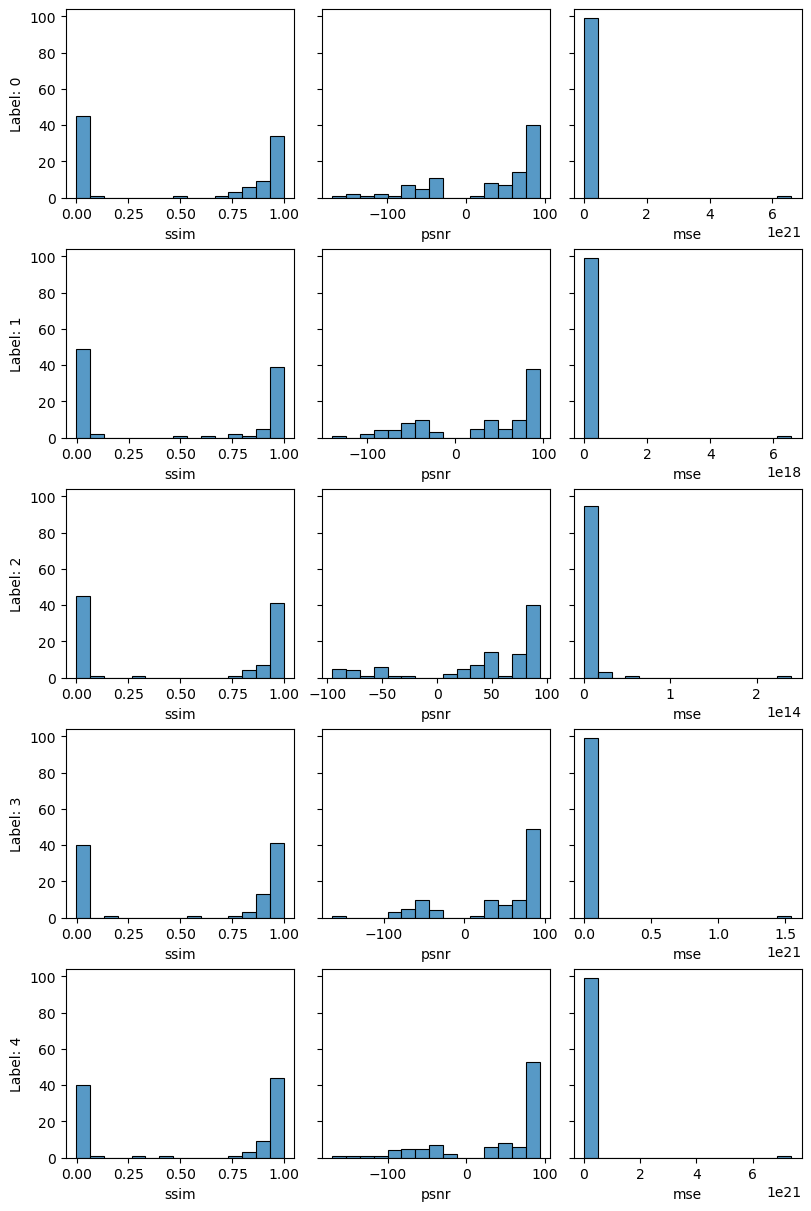

In [60]:
fig, axs = plt.subplots(5, 3, sharey=True, constrained_layout = True, figsize=(8,12))
for label in range(0, 5):
    for i, metric in enumerate(['ssim', 'psnr', 'mse']):
        sns.histplot(data=df[df['label'] == label], x=metric, bins=15, ax=axs[label][i])
        axs[label][i].set_ylabel(f'Label: {label}')


# set the spacing between subplots
plt.show()
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

# for ax in axs.flat:

<AxesSubplot:xlabel='ssim', ylabel='Count'>

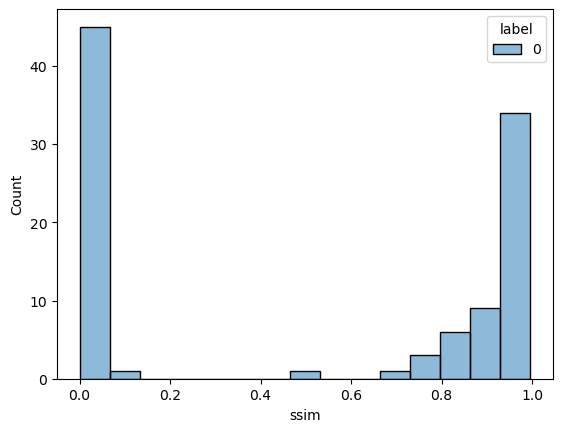

In [45]:
sns.histplot(data=df[df['label'] == 0], x='ssim', hue='label', bins=15, palette='tab10', ax=)

In [29]:
def above_70(series):
    return (series > 0.7).sum()

In [36]:
df.groupby('label').agg({'ssim': ('mean', 'max', 'count', above_70), 'psnr': ('mean', 'max', 'count'), 'mse': ('mean', 'min', 'count')}, 'count').to_csv('label_agg_dr_above_70.csv')

In [28]:
df.groupby('label').describe()

mse                                                            \
       count          mean           std       min       25%       50%   
label                                                                    
0      100.0  6.668626e+19  6.598998e+20  0.000029  0.000378  0.004875   
1      100.0  6.566529e+16  6.565206e+17  0.000018  0.000228  0.480348   
2      100.0  3.749541e+12  2.472320e+13  0.000031  0.000197  0.002701   
3      100.0  1.545534e+19  1.545533e+20  0.000027  0.000268  0.001496   
4      100.0  7.379554e+19  7.371522e+20  0.000029  0.000200  0.001030   

                                    psnr             ...             \
                75%           max  count       mean  ...        75%   
label                                                ...              
0      6.556836e+08  6.599401e+21  100.0  28.008597  ...  82.359183   
1      4.656611e+08  6.565219e+18  100.0  30.120989  ...  84.563882   
2      5.338611e+01  2.399677e+14  100.0  44.232144  ...  85.183665   
3      8.859103e+01  1.545533e+21  100.0  41.321155  ...  83.845067   
4      1.213136e+08  7.371600e+21  100.0  35.613659  ...  85.117331   

                   ssim                                                        \
             max  count      mean       std       min           25%       50%   
label                                                                           
0      93.495920  100.0  0.500053  0.466045 -0.000078  1.344459e-11  0.781551   
1      95.630492  100.0  0.465292  0.476398 -0.002261  1.068656e-15  0.107123   
2      93.275541  100.0  0.511897  0.474982 -0.001016  4.012872e-11  0.831188   
3      93.746503  100.0  0.558310  0.466956 -0.001751  1.393111e-11  0.887660   
4      93.524867  100.0  0.553006  0.469549 -0.001473  1.612302e-11  0.895171   

                           
            75%       max  
label                      
0      0.968459  0.996553  
1      0.977025  0.998416  
2      0.974644  0.997128  
3      0.974188  0.998399  
4      0.978263  0.997378  

[5 rows x 24 columns]